# multi scale ssim calculation

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import numpy as np
np.set_printoptions(threshold=np.nan)
import tensorflow as tf
import time
import pandas as pd
import matplotlib.pyplot as plt
import progressbar

In [10]:
# params
image_dim, result_dim, filter_dim, pool_size = 96, 86, 11, 2
train_size, test_size = 500, 140

In [3]:
# data input
data_path = 'https://raw.githubusercontent.com/michaelneuder/image_quality_analysis/master/data/sample_data/'

# train data --- 500 images, 96x96 pixels
orig_500_raw = pd.read_csv('{}orig_500.txt'.format(data_path), header=None, delim_whitespace = True)
recon_500_raw = pd.read_csv('{}recon_500.txt'.format(data_path), header=None, delim_whitespace = True)

# test data --- 140 images, 96x96 pixels
orig_140_raw = pd.read_csv('{}orig_140.txt'.format(data_path), header=None, delim_whitespace = True)
recon_140_raw = pd.read_csv('{}recon_140.txt'.format(data_path), header=None, delim_whitespace = True)

In [4]:
# reshape
orig_500 = np.reshape(orig_500_raw.values, (train_size, image_dim, image_dim))
recon_500 = np.reshape(recon_500_raw.values, (train_size, image_dim, image_dim))
orig_140 = np.reshape(orig_140_raw.values, (test_size, image_dim, image_dim))
recon_140 = np.reshape(recon_140_raw.values, (test_size, image_dim, image_dim))

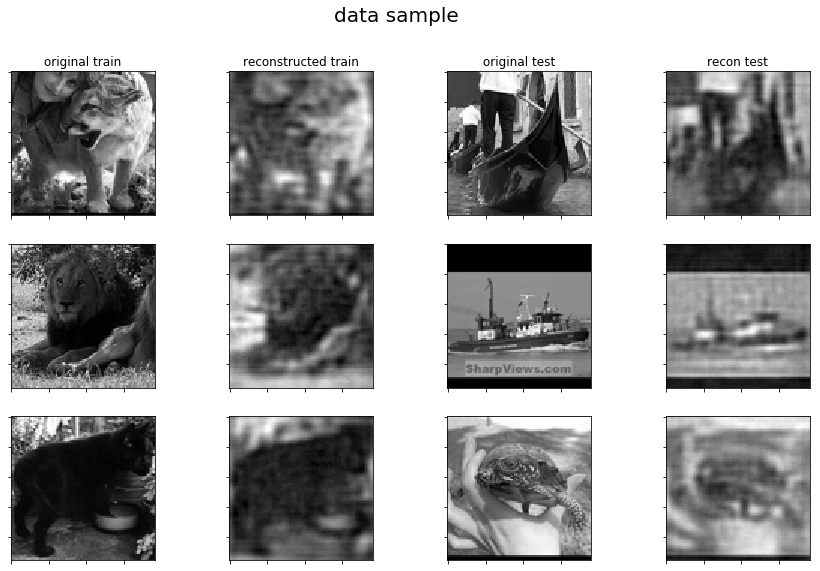

In [6]:
# make sure pictures look right
f, axarr = plt.subplots(nrows=3,ncols=4, figsize=(15,9))
for i in range(3):
    index = np.random.randint(140)
    axarr[i,0].imshow(orig_500[index,:,:], cmap='gray')
    axarr[i,1].imshow(recon_500[index,:,:], cmap='gray')
    axarr[i,2].imshow(orig_140[index,:,:], cmap='gray')
    axarr[i,3].imshow(recon_140[index,:,:], cmap='gray')

axarr[0,0].set_title('original train')
axarr[0,1].set_title('reconstructed train')
axarr[0,2].set_title('original test')
axarr[0,3].set_title('recon test')
for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('data sample', size=20)
plt.show()

In [9]:
def average_pool(window):
    return np.mean(window)

In [28]:
# downsample images
reduce_im_orig_2, reduce_im_recon_2 = [], []
test_image_orig, test_image_recon = orig_500[0], recon_500[0]
number_pools = int(image_dim / pool_size)
for i in range(number_pools):
    for j in range(number_pools):
        orig_pool = test_image_orig[i*pool_size:i*pool_size+pool_size, j*pool_size:j*pool_size+pool_size]
        recon_pool = test_image_recon[i*pool_size:i*pool_size+pool_size, j*pool_size:j*pool_size+pool_size]
        temp_orig, temp_recon = average_pool(orig_pool), average_pool(recon_pool)
        reduce_im_orig_2.append(temp_orig)
        reduce_im_recon_2.append(temp_recon)

In [32]:
# 48 x 48
np.asarray(reduce_im_orig_2).shape

reduce_im_orig_2 = np.reshape(np.asarray(reduce_im_orig_2), (48,48))
reduce_im_recon_2 = np.reshape(np.asarray(reduce_im_recon_2), (48,48))

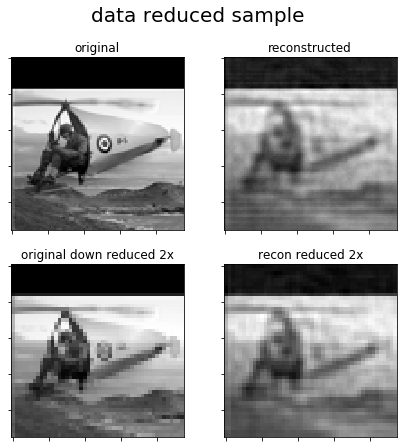

In [42]:
f, axarr = plt.subplots(nrows=2,ncols=2, figsize=(7,7))
for i in range(3):
    index = np.random.randint(140)
    axarr[0,0].imshow(test_image_orig, cmap='gray')
    axarr[0,1].imshow(test_image_recon, cmap='gray')
    axarr[1,0].imshow(reduce_im_orig_2, cmap='gray')
    axarr[1,1].imshow(reduce_im_recon_2, cmap='gray')

axarr[0,0].set_title('original')
axarr[0,1].set_title('reconstructed')
axarr[1,0].set_title('original down reduced 2x')
axarr[1,1].set_title('recon reduced 2x')
for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('data reduced sample', size=20)
plt.show()

In [44]:
# downsample images
reduce_im_orig_4, reduce_im_recon_4 = [], []
number_pools = int(48 / pool_size)
for i in range(number_pools):
    for j in range(number_pools):
        orig_pool = reduce_im_orig_2[i*pool_size:i*pool_size+pool_size, j*pool_size:j*pool_size+pool_size]
        recon_pool = reduce_im_recon_2[i*pool_size:i*pool_size+pool_size, j*pool_size:j*pool_size+pool_size]
        temp_orig, temp_recon = average_pool(orig_pool), average_pool(recon_pool)
        reduce_im_orig_4.append(temp_orig)
        reduce_im_recon_4.append(temp_recon)
reduce_im_orig_4, reduce_im_recon_4 = np.asarray(reduce_im_orig_4), np.asarray(reduce_im_recon_4)

In [47]:
# 24 x 24
reduce_im_orig_4.shape

(24, 24)

In [46]:
reduce_im_orig_4 = np.reshape(np.asarray(reduce_im_orig_4), (24,24))
reduce_im_recon_4 = np.reshape(np.asarray(reduce_im_recon_4), (24,24))

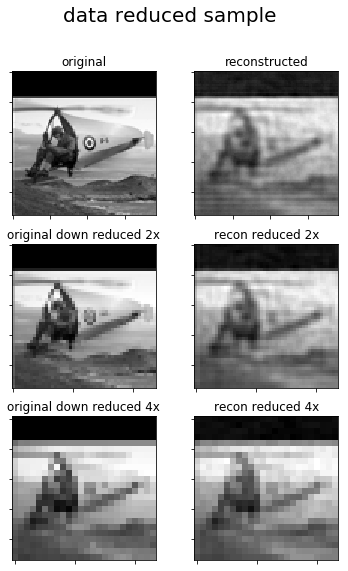

In [52]:
f, axarr = plt.subplots(nrows=3,ncols=2, figsize=(6,9))
for i in range(3):
    index = np.random.randint(140)
    axarr[0,0].imshow(test_image_orig, cmap='gray')
    axarr[0,1].imshow(test_image_recon, cmap='gray')
    axarr[1,0].imshow(reduce_im_orig_2, cmap='gray')
    axarr[1,1].imshow(reduce_im_recon_2, cmap='gray')
    axarr[2,0].imshow(reduce_im_orig_4, cmap='gray')
    axarr[2,1].imshow(reduce_im_recon_4, cmap='gray')

axarr[0,0].set_title('original')
axarr[0,1].set_title('reconstructed')
axarr[1,0].set_title('original down reduced 2x')
axarr[1,1].set_title('recon reduced 2x')
axarr[2,0].set_title('original down reduced 4x')
axarr[2,1].set_title('recon reduced 4x')

for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('data reduced sample', size=20)
plt.savefig('down_sample.png')
plt.show()